[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/detic-detecting-20k-classes-using-image-level-supervision/blob/main/detic_demo.ipynb)

# Detic: Detecting 20K Classes Using Image-level Supervision

- Original paper: https://arxiv.org/abs/2201.02605
- Official GitHub: https://github.com/facebookresearch/Detic

## Overview

![TLDR](detic-tldr.jpeg)

## Pre-requisites

### Install Detectron2

In [16]:
import torch, os
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  cu102


In [17]:
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

### Clone and install Detic

In [18]:
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules

fatal: destination path 'Detic' already exists and is not an empty directory.


In [85]:
try: os.chdir("Detic")
except OSError: print("Already changed!")       

Already changed!


## Configuration

In [22]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
import requests
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [23]:
# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

## Build the detector and download our pretrained weights

In [25]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE = "cpu" # run with cpu instead of CUDA

In [26]:
predictor = DefaultPredictor(cfg)

### Setup the model's vocabulary using build-in datasets

In [27]:
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

In [28]:
vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


## Run inference on test images

In [58]:
def download_image(image_url):
    res = requests.get(url, stream=True)
    return cv2.imdecode(np.asarray(bytearray(res.content)), 1)

def cv2_to_PIL(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

In [31]:
image_url = 'https://static1.hoy.es/www/pre2017/multimedia/noticias/201508/10/media/87373403.jpg'
# image_url = "https://i2.wp.com/www.buenossaborespanama.com/wp-content/uploads/2021/08/choripan-traditional-argentina-sandwich-with-chorizo-and-chimichurri-sauce-on-wooden-table-scaled.jpg"
test_images = [f'../test-images/conurbano-{x}.jpg' for x in range(1,5)]

In [ ]:
im = cv2.imread('../test-images/conurbano-1.jpg')

In [60]:
im = download_image(image_url)

### Use selected vocabulary e.g. LVIS, OpenImages, etc.

In [66]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

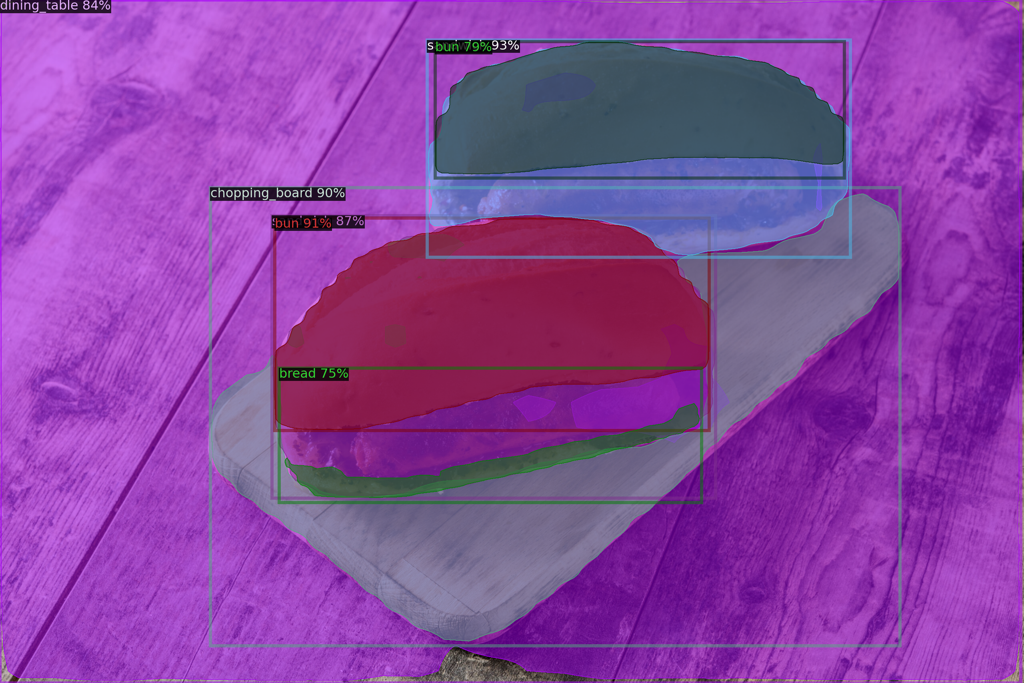

In [68]:
out_img = cv2_to_PIL(out.get_image()[:, :, ::-1])
out_img.thumbnail((1024,1024))
out_img

### Use a custom vocabulary with a pre-trained CLIP

In [77]:
from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb

In [78]:
if '__test' in([x for x in MetadataCatalog.keys()]): MetadataCatalog.pop('__test')
metadata = MetadataCatalog.get("__test")
metadata.thing_classes = ['choripan', 'mouse'] # # Change here to try your own vocabularies!

In [82]:
vocabulary = 'custom'
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.6
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

Loading pretrained CLIP


In [83]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

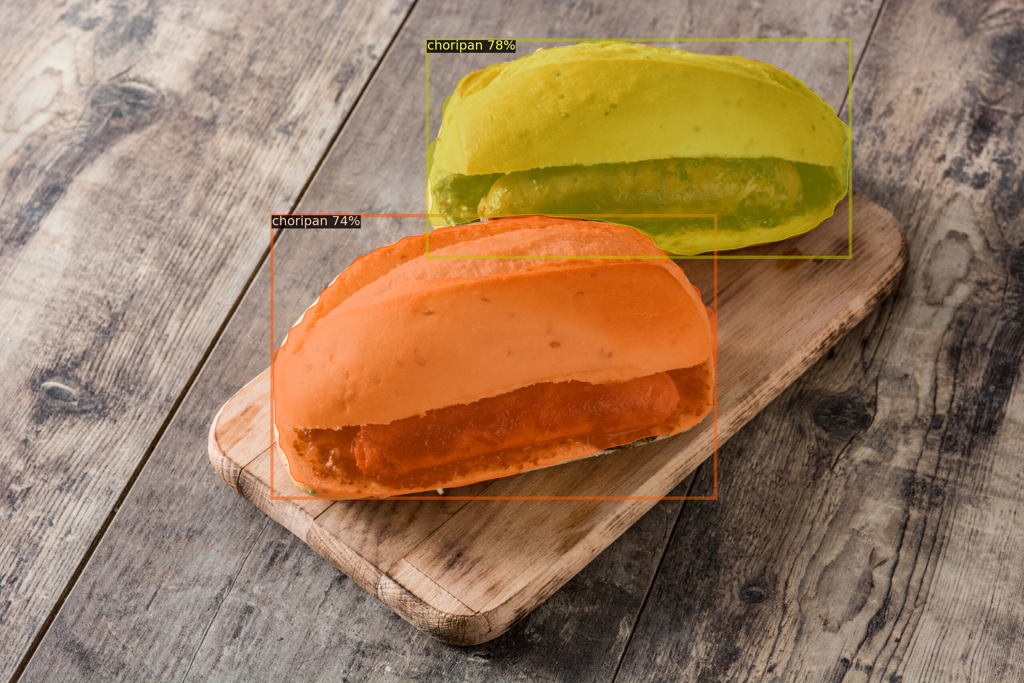

In [84]:
out_img = cv2_to_PIL(out.get_image()[:, :, ::-1])
out_img.thumbnail((1024,1024))
out_img